In [67]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [68]:
import sys
import os
import torch
import torchsummary

In [69]:
from experiments.image_clf.config import Config
from experiments.image_clf.data import get_dls
from experiments.image_clf.models import CNN__MLP_tiny_28x28

In [70]:
from legoml.utils.logging import get_logger
from legoml.utils.seed import set_seed

In [71]:
import matplotlib.pyplot as plt

%matplotlib inline

In [72]:
device = torch.device("mps")
set_seed(42)
config = Config(max_epochs=1, data_root="../../raw_data/")

In [73]:
model = CNN__MLP_tiny_28x28()

In [74]:
model

CNN__MLP_tiny_28x28(
  (0): Conv_3x3__BnAct__Pool(
    (0): Conv_3x3__BnAct(
      (0): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=True)
    )
    (1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=True)
  )
  (1): Conv_3x3__BnAct(
    (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
  )
  (2): Conv_3x3__BnAct__Pool(
    (0): Conv_3x3__BnAct(
      (0): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=True)
    )
    (1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=True)
  )
  (3): Conv_3x3__BnAct(
    (0

In [75]:
from legoml.core.context import Context
from legoml.callbacks.checkpoint import CheckpointCallback

eval_context = Context(
    config=config,
    model=model,
    loss_fn=torch.nn.CrossEntropyLoss(),
    device=device,
)

checkpoint_path = "../../runs/train_img_clf/run_20250824_183653/artifacts/checkpoints/ckpt_last.pt"
_ = CheckpointCallback.load_into(
    context=eval_context,
    path=checkpoint_path,
    map_location=device.type,
)


In [76]:
train_dl, eval_dl = get_dls(config)

2025-08-24 19:44:53 [info     ] Created data loaders           train_size=938 val_size=313


In [77]:
single_batch = next(iter(eval_dl))

In [80]:
images, targets = single_batch.inputs, single_batch.targets

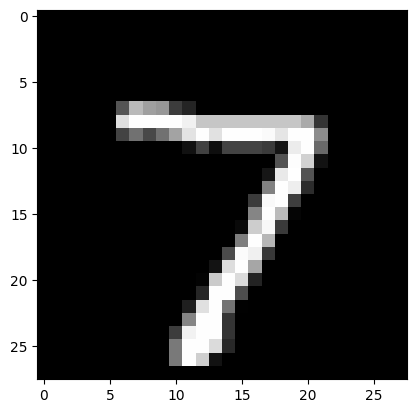

In [81]:
plt.imshow(images[0].reshape((28, 28, 1)), cmap="gray")
plt.show();

In [82]:
targets[0].item()

7

## Model outputs

In [83]:
next(eval_context.model.parameters()).device

device(type='cpu')

In [84]:
images[0].shape

torch.Size([1, 28, 28])

In [85]:
torchsummary.summary(eval_context.model.cpu(), images[0].shape)

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 32, 28, 28]             288
       BatchNorm2d-2           [-1, 32, 28, 28]              64
              ReLU-3           [-1, 32, 28, 28]               0
         MaxPool2d-4           [-1, 32, 14, 14]               0
            Conv2d-5           [-1, 32, 14, 14]           9,216
       BatchNorm2d-6           [-1, 32, 14, 14]              64
              ReLU-7           [-1, 32, 14, 14]               0
            Conv2d-8           [-1, 64, 14, 14]          18,432
       BatchNorm2d-9           [-1, 64, 14, 14]             128
             ReLU-10           [-1, 64, 14, 14]               0
        MaxPool2d-11             [-1, 64, 7, 7]               0
           Conv2d-12             [-1, 64, 7, 7]          36,864
      BatchNorm2d-13             [-1, 64, 7, 7]             128
             ReLU-14             [-1, 6

In [86]:
_ = eval_context.model.to(device).eval()
with torch.no_grad():
    model_op = eval_context.model(images.to(device))

In [87]:
for idx in range(len(targets))[:5]:
    pred = model_op[idx].argmax(dim=-1).item()
    tgt = targets[idx].item()
    print(f"Pred: {pred}, target: {tgt}")

Pred: 7, target: 7
Pred: 2, target: 2
Pred: 1, target: 1
Pred: 0, target: 0
Pred: 4, target: 4


In [112]:
from collections import OrderedDict

class TestModel(torch.nn.Sequential):
    def __init__(self):
        super().__init__(
            OrderedDict([
                ('fc1', torch.nn.Linear(2, 10)),
                ('activation', torch.nn.ReLU(inplace=True)),
                ('fc2', torch.nn.Linear(10, 2))
            ])
        )

In [113]:
md = TestModel()

In [114]:
md.fc1

Linear(in_features=2, out_features=10, bias=True)

In [116]:
md

TestModel(
  (fc1): Linear(in_features=2, out_features=10, bias=True)
  (activation): ReLU(inplace=True)
  (fc2): Linear(in_features=10, out_features=2, bias=True)
)

In [118]:
import torch.nn as nn

In [121]:
class AEBackbone__MLP(nn.Sequential):
    def __init__(self, encoder: nn.Module):
        super().__init__(
            OrderedDict(
                [
                    ("encoder", encoder),
                    ("head", nn.Linear(128, 10)),  # [10]
                ]
            )
        )

In [122]:
aemlp = AEBackbone__MLP(md)

In [124]:
aemlp.encoder

TestModel(
  (fc1): Linear(in_features=2, out_features=10, bias=True)
  (activation): ReLU(inplace=True)
  (fc2): Linear(in_features=10, out_features=2, bias=True)
)

In [13]:
import torch
import torch.nn as nn
from collections import OrderedDict

In [20]:
class NormAct(nn.Module):
    def __init__(self, norm: nn.Module, act: nn.Module):
        super().__init__()
        self.norm = norm
        self.act = act

    def forward(self, x: torch.Tensor): return self.act(self.norm(x))

In [31]:
class ConvLayer(nn.Sequential):
    def __init__(self, c1, c2, norm_fn, act_fn):
        norm = norm_fn(c2)
        act = act_fn()
        conv = nn.Conv2d(c1, c2, 3, 1, 1)
        layers = [conv, NormAct(norm=norm, act=act)]
        super().__init__(*layers)
        self.conv = conv
        self.norm = norm
        self.act = act


In [32]:
cv = ConvLayer(3, 16, norm_fn=nn.BatchNorm2d, act_fn=nn.ReLU)

In [34]:
cv.norm

BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)

In [35]:
cv.act = nn.ReLU6()

In [36]:
cv

ConvLayer(
  (0): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (1): NormAct(
    (norm): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (act): ReLU()
  )
  (conv): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (norm): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (act): ReLU6()
)